<h1> Feature Engineering </h1>

In this notebook, you will learn how to incorporate feature engineering into your pipeline.
<ul>
<li> Working with feature columns </li>
<li> Adding feature crosses in TensorFlow </li>
<li> Reading data from BigQuery </li>
<li> Creating datasets using Dataflow </li>
<li> Using a wide-and-deep model </li>
</ul>

In [1]:
import tensorflow as tf
import apache_beam as beam
import shutil
print(tf.__version__)

/usr/local/envs/py2env/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


1.8.0


/usr/local/envs/py2env/lib/python2.7/site-packages/simplejson/encoder.py:296: DeprecationWarning: Interpreting naive datetime as local 2018-08-08 13:53:28.197933. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


<h2> 1. Environment variables for project and bucket </h2>

<li> Your project id is the *unique* string that identifies your project (not the project name). You can find this from the GCP Console dashboard's Home page.  My dashboard reads:  <b>Project ID:</b> cloud-training-demos </li>
<li> Cloud training often involves saving and restoring model files. Therefore, we should <b>create a single-region bucket</b>. If you don't have a bucket already, I suggest that you create one from the GCP console (because it will dynamically check whether the bucket name you want is available) </li>
</ol>
<b>Change the cell below</b> to reflect your Project ID and bucket name.


In [2]:
import os
REGION = 'us-central1' # Choose an available region for Cloud MLE from https://cloud.google.com/ml-engine/docs/regions.
BUCKET = 'qwiklabs-gcp-771407dbf531ec59' # REPLACE WITH YOUR BUCKET NAME. Use a regional bucket in the region you selected.
PROJECT = 'qwiklabs-gcp-771407dbf531ec59'    # CHANGE THIS

/usr/local/envs/py2env/lib/python2.7/site-packages/simplejson/encoder.py:296: DeprecationWarning: Interpreting naive datetime as local 2018-08-08 13:54:37.247933. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [3]:
# for bash
os.environ['PROJECT'] = PROJECT
os.environ['BUCKET'] = BUCKET
os.environ['REGION'] = REGION
os.environ['TFVERSION'] = '1.8' 

/usr/local/envs/py2env/lib/python2.7/site-packages/simplejson/encoder.py:296: DeprecationWarning: Interpreting naive datetime as local 2018-08-08 13:55:08.027926. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [4]:
%bash
gcloud config set project $PROJECT
gcloud config set compute/region $REGION

Updated property [core/project].
Updated property [compute/region].
/usr/local/envs/py2env/lib/python2.7/site-packages/simplejson/encoder.py:296: DeprecationWarning: Interpreting naive datetime as local 2018-08-08 13:55:11.712932. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


<h2> 2. Specifying query to pull the data </h2>

Let's pull out a few extra columns from the timestamp.

In [5]:
def create_query(phase, EVERY_N):
  if EVERY_N == None:
    EVERY_N = 4 #use full dataset
    
  #select and pre-process fields
  base_query = """
SELECT
  (tolls_amount + fare_amount) AS fare_amount,
  DAYOFWEEK(pickup_datetime) AS dayofweek,
  HOUR(pickup_datetime) AS hourofday,
  pickup_longitude AS pickuplon,
  pickup_latitude AS pickuplat,
  dropoff_longitude AS dropofflon,
  dropoff_latitude AS dropofflat,
  passenger_count*1.0 AS passengers,
  CONCAT(STRING(pickup_datetime), STRING(pickup_longitude), STRING(pickup_latitude), STRING(dropoff_latitude), STRING(dropoff_longitude)) AS key
FROM
  [nyc-tlc:yellow.trips]
WHERE
  trip_distance > 0
  AND fare_amount >= 2.5
  AND pickup_longitude > -78
  AND pickup_longitude < -70
  AND dropoff_longitude > -78
  AND dropoff_longitude < -70
  AND pickup_latitude > 37
  AND pickup_latitude < 45
  AND dropoff_latitude > 37
  AND dropoff_latitude < 45
  AND passenger_count > 0
  """
  
  #add subsampling criteria by modding with hashkey
  if phase == 'train': 
    query = "{} AND ABS(HASH(pickup_datetime)) % {} < 2".format(base_query,EVERY_N)
  elif phase == 'valid': 
    query = "{} AND ABS(HASH(pickup_datetime)) % {} == 2".format(base_query,EVERY_N)
  elif phase == 'test':
    query = "{} AND ABS(HASH(pickup_datetime)) % {} == 3".format(base_query,EVERY_N)
  return query
    
print create_query('valid', 100) #example query using 1% of data


SELECT
  (tolls_amount + fare_amount) AS fare_amount,
  DAYOFWEEK(pickup_datetime) AS dayofweek,
  HOUR(pickup_datetime) AS hourofday,
  pickup_longitude AS pickuplon,
  pickup_latitude AS pickuplat,
  dropoff_longitude AS dropofflon,
  dropoff_latitude AS dropofflat,
  passenger_count*1.0 AS passengers,
  CONCAT(STRING(pickup_datetime), STRING(pickup_longitude), STRING(pickup_latitude), STRING(dropoff_latitude), STRING(dropoff_longitude)) AS key
FROM
  [nyc-tlc:yellow.trips]
WHERE
  trip_distance > 0
  AND fare_amount >= 2.5
  AND pickup_longitude > -78
  AND pickup_longitude < -70
  AND dropoff_longitude > -78
  AND dropoff_longitude < -70
  AND pickup_latitude > 37
  AND pickup_latitude < 45
  AND dropoff_latitude > 37
  AND dropoff_latitude < 45
  AND passenger_count > 0
   AND ABS(HASH(pickup_datetime)) % 100 == 2


/usr/local/envs/py2env/lib/python2.7/site-packages/simplejson/encoder.py:296: DeprecationWarning: Interpreting naive datetime as local 2018-08-08 14:05:18.988969. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


Try the query above in https://bigquery.cloud.google.com/table/nyc-tlc:yellow.trips if you want to see what it does (ADD LIMIT 10 to the query!)

<h2> 3. Preprocessing Dataflow job from BigQuery </h2>

This code reads from BigQuery and saves the data as-is on Google Cloud Storage.  We can do additional preprocessing and cleanup inside Dataflow, but then we'll have to remember to repeat that prepreprocessing during inference. It is better to use tf.transform which will do this book-keeping for you, or to do preprocessing within your TensorFlow model. We will look at this in future notebooks. For now, we are simply moving data from BigQuery to CSV using Dataflow.

While we could read from BQ directly from TensorFlow (See: https://www.tensorflow.org/api_docs/python/tf/contrib/cloud/BigQueryReader), it is quite convenient to export to CSV and do the training off CSV.  Let's use Dataflow to do this at scale.

Because we are running this on the Cloud, you should go to the GCP Console (https://console.cloud.google.com/dataflow) to look at the status of the job. It will take several minutes for the preprocessing job to launch.

In [6]:
%bash
gsutil -m rm -rf gs://$BUCKET/taxifare/ch4/taxi_preproc/

CommandException: 1 files/objects could not be removed.
/usr/local/envs/py2env/lib/python2.7/site-packages/simplejson/encoder.py:296: DeprecationWarning: Interpreting naive datetime as local 2018-08-08 14:07:17.635930. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [7]:
import datetime

####
# Arguments:
#   -rowdict: Dictionary. The beam bigquery reader returns a PCollection in
#     which each row is represented as a python dictionary
# Returns:
#   -rowstring: a comma separated string representation of the record with dayofweek
#     converted from int to string (e.g. 3 --> Tue)
####
def to_csv(rowdict):
  days = ['null', 'Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']
  CSV_COLUMNS = 'fare_amount,dayofweek,hourofday,pickuplon,pickuplat,dropofflon,dropofflat,passengers,key'.split(',')
  rowdict['dayofweek'] = days[rowdict['dayofweek']]
  rowstring = ','.join([str(rowdict[k]) for k in CSV_COLUMNS])
  return rowstring


####
# Arguments:
#   -EVERY_N: Integer. Sample one out of every N rows from the full dataset.
#     Larger values will yield smaller sample
#   -RUNNER: 'DirectRunner' or 'DataflowRunner'. Specfy to run the pipeline
#     locally or on Google Cloud respectively. 
# Side-effects:
#   -Creates and executes dataflow pipeline. 
#     See https://beam.apache.org/documentation/programming-guide/#creating-a-pipeline
####
def preprocess(EVERY_N, RUNNER):
  job_name = 'preprocess-taxifeatures' + '-' + datetime.datetime.now().strftime('%y%m%d-%H%M%S')
  print 'Launching Dataflow job {} ... hang on'.format(job_name)
  OUTPUT_DIR = 'gs://{0}/taxifare/ch4/taxi_preproc/'.format(BUCKET)

  #dictionary of pipeline options
  options = {
    'staging_location': os.path.join(OUTPUT_DIR, 'tmp', 'staging'),
    'temp_location': os.path.join(OUTPUT_DIR, 'tmp'),
    'job_name': 'preprocess-taxifeatures' + '-' + datetime.datetime.now().strftime('%y%m%d-%H%M%S'),
    'project': PROJECT,
    'runner': RUNNER
  }
  #instantiate PipelineOptions object using options dictionary
  opts = beam.pipeline.PipelineOptions(flags=[], **options)
  #instantantiate Pipeline object using PipelineOptions
  p = beam.Pipeline(options=opts)
  for phase in ['train', 'valid']:
    query = create_query(phase, EVERY_N) 
    outfile = os.path.join(OUTPUT_DIR, '{}.csv'.format(phase))
    (
      p | 'read_{}'.format(phase) >> beam.io.Read(beam.io.BigQuerySource(query=query))
        | 'tocsv_{}'.format(phase) >> beam.Map(to_csv)
        | 'write_{}'.format(phase) >> beam.io.Write(beam.io.WriteToText(outfile))
    )

  p.run()

/usr/local/envs/py2env/lib/python2.7/site-packages/simplejson/encoder.py:296: DeprecationWarning: Interpreting naive datetime as local 2018-08-08 14:12:33.847951. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


Run pipeline locally

In [8]:
preprocess(50*10000, 'DirectRunner') 

Launching Dataflow job preprocess-taxifeatures-180808-141236 ... hang on


/usr/local/envs/py2env/lib/python2.7/site-packages/simplejson/encoder.py:296: DeprecationWarning: Interpreting naive datetime as local 2018-08-08 14:12:36.776901. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)
/usr/local/envs/py2env/lib/python2.7/site-packages/oauth2client/contrib/gce.py:99: UserWarning: You have requested explicit scopes to be used with a GCE service account.
Using this argument will have no effect on the actual scopes for tokens
requested. These scopes are set at VM instance creation time and
can't be overridden in the request.

  warnings.warn(_SCOPES_WARNING)
/usr/local/envs/py2env/lib/python2.7/site-packages/apache_beam/io/gcp/gcsio.py:113: DeprecationWarning: object() takes no parameters
  super(GcsIO, cls).__new__(cls, storage_client))


Run pipleline on cloud on a larger sample size.

In [9]:
preprocess(50*100, 'DataflowRunner') 
#change first arg to None to preprocess full dataset

Launching Dataflow job preprocess-taxifeatures-180808-141332 ... hang on


/usr/local/envs/py2env/lib/python2.7/site-packages/apache_beam/coders/typecoders.py:135: UserWarning: Using fallback coder for typehint: Any.
  warnings.warn('Using fallback coder for typehint: %r.' % typehint)
/usr/local/envs/py2env/lib/python2.7/site-packages/simplejson/encoder.py:296: DeprecationWarning: Interpreting naive datetime as local 2018-08-08 14:13:32.184914. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


Once the job completes, observe the files created in Google Cloud Storage

In [10]:
%bash
gsutil ls -l gs://$BUCKET/taxifare/ch4/taxi_preproc/

    114726  2018-08-08T14:13:07Z  gs://qwiklabs-gcp-771407dbf531ec59/taxifare/ch4/taxi_preproc/train.csv-00000-of-00005
    108805  2018-08-08T14:13:07Z  gs://qwiklabs-gcp-771407dbf531ec59/taxifare/ch4/taxi_preproc/train.csv-00001-of-00005
    114331  2018-08-08T14:13:07Z  gs://qwiklabs-gcp-771407dbf531ec59/taxifare/ch4/taxi_preproc/train.csv-00002-of-00005
    114927  2018-08-08T14:13:07Z  gs://qwiklabs-gcp-771407dbf531ec59/taxifare/ch4/taxi_preproc/train.csv-00003-of-00005
    113892  2018-08-08T14:13:07Z  gs://qwiklabs-gcp-771407dbf531ec59/taxifare/ch4/taxi_preproc/train.csv-00004-of-00005
    113579  2018-08-08T14:13:06Z  gs://qwiklabs-gcp-771407dbf531ec59/taxifare/ch4/taxi_preproc/valid.csv-00000-of-00002
    106762  2018-08-08T14:13:06Z  gs://qwiklabs-gcp-771407dbf531ec59/taxifare/ch4/taxi_preproc/valid.csv-00001-of-00002
                                 gs://qwiklabs-gcp-771407dbf531ec59/taxifare/ch4/taxi_preproc/tmp/
TOTAL: 7 objects, 787022 bytes (768.58 KiB)


/usr/local/envs/py2env/lib/python2.7/site-packages/simplejson/encoder.py:296: DeprecationWarning: Interpreting naive datetime as local 2018-08-08 14:16:21.362964. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [11]:
%bash
#print first 10 lines of first shard of train.csv
gsutil cat "gs://$BUCKET/taxifare/ch4/taxi_preproc/train.csv-00000-of-*" | head

30.5,Fri,0,-73.9804077148,40.7457847595,-74.0038757324,40.6466941833,3.0,2015-03-20 00:37:15.000000-73.980440.745840.6467-74.0039
7.4,Sat,0,-73.972259,40.752311,-73.987083,40.728431,3.0,2009-01-17 00:04:32.000000-73.972340.752340.7284-73.9871
17.5,Fri,0,-74.00055,40.735609,-73.978469,40.790794,1.0,2013-01-25 00:28:18.000000-74.000640.735640.7908-73.9785
17.3,Thu,0,-73.989998,40.761777,-73.985523,40.688012,1.0,2009-05-28 00:09:17.000000-73.9940.761840.688-73.9855
15.3,Tue,0,-73.996457,40.742907,-73.96584,40.677997,1.0,2011-11-29 00:46:00.000000-73.996540.742940.678-73.9658
31.0,Tue,0,-73.7764358521,40.6451301575,-73.9119033813,40.7053756714,4.0,2015-03-24 00:34:01.000000-73.776440.645140.7054-73.9119
22.1,Tue,0,-73.979457,40.764863,-73.926718,40.863352,3.0,2011-11-29 00:46:00.000000-73.979540.764940.8634-73.9267
11.8,Sun,0,-73.983132,40.722446,-73.956341,40.767218,2.0,2009-04-12 00:40:41.000000-73.983140.722440.7672-73.9563
19.0,Wed,0,-73.9899215698,40.7331581116,-73.9257507324,40.75875

/usr/local/envs/py2env/lib/python2.7/site-packages/simplejson/encoder.py:296: DeprecationWarning: Interpreting naive datetime as local 2018-08-08 14:17:22.271944. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


<h2> 4. Develop model with new inputs </h2>

Download the first shard of the preprocessed data to enable local development.

In [12]:
%bash
mkdir sample
gsutil cp "gs://$BUCKET/taxifare/ch4/taxi_preproc/train.csv-00000-of-*" sample/train.csv
gsutil cp "gs://$BUCKET/taxifare/ch4/taxi_preproc/valid.csv-00000-of-*" sample/valid.csv

mkdir: cannot create directory ‘sample’: File exists
Copying gs://qwiklabs-gcp-771407dbf531ec59/taxifare/ch4/taxi_preproc/train.csv-00000-of-00005...
/ [1 files][112.0 KiB/112.0 KiB]                                                
Operation completed over 1 objects/112.0 KiB.                                    
Copying gs://qwiklabs-gcp-771407dbf531ec59/taxifare/ch4/taxi_preproc/valid.csv-00000-of-00002...
/ [1 files][110.9 KiB/110.9 KiB]                                                
Operation completed over 1 objects/110.9 KiB.                                    
/usr/local/envs/py2env/lib/python2.7/site-packages/simplejson/encoder.py:296: DeprecationWarning: Interpreting naive datetime as local 2018-08-08 14:17:51.178945. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


We have two new inputs in the INPUT_COLUMNS, three engineered features, and the estimator involves bucketization and feature crosses.

In [13]:
!grep -A 20 "INPUT_COLUMNS =" taxifare/trainer/model.py

INPUT_COLUMNS = [
    # Define features
    tf.feature_column.categorical_column_with_vocabulary_list('dayofweek', vocabulary_list = ['Sun', 'Mon', 'Tues', 'Wed', 'Thu', 'Fri', 'Sat']),
    tf.feature_column.categorical_column_with_identity('hourofday', num_buckets = 24),

    # Numeric columns
    tf.feature_column.numeric_column('pickuplat'),
    tf.feature_column.numeric_column('pickuplon'),
    tf.feature_column.numeric_column('dropofflat'),
    tf.feature_column.numeric_column('dropofflon'),
    tf.feature_column.numeric_column('passengers'),
    
    # Engineered features that are created in the input_fn
    tf.feature_column.numeric_column('latdiff'),
    tf.feature_column.numeric_column('londiff'),
    tf.feature_column.numeric_column('euclidean')
]

# Build the estimator
def build_estimator(model_dir, nbuckets, hidden_units):
    """


/usr/local/envs/py2env/lib/python2.7/site-packages/simplejson/encoder.py:296: DeprecationWarning: Interpreting naive datetime as local 2018-08-08 14:19:33.878936. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [14]:
!grep -A 50 "build_estimator" taxifare/trainer/model.py

def build_estimator(model_dir, nbuckets, hidden_units):
    """
     Build an estimator starting from INPUT COLUMNS.
     These include feature transformations and synthetic features.
     The model is a wide-and-deep model.
  """

    # Input columns
    (dayofweek, hourofday, plat, plon, dlat, dlon, pcount, latdiff, londiff, euclidean) = INPUT_COLUMNS

    # Bucketize the lats & lons
    latbuckets = np.linspace(38.0, 42.0, nbuckets).tolist()
    lonbuckets = np.linspace(-76.0, -72.0, nbuckets).tolist()
    b_plat = tf.feature_column.bucketized_column(plat, latbuckets)
    b_dlat = tf.feature_column.bucketized_column(dlat, latbuckets)
    b_plon = tf.feature_column.bucketized_column(plon, lonbuckets)
    b_dlon = tf.feature_column.bucketized_column(dlon, lonbuckets)

    # Feature cross
    ploc = tf.feature_column.crossed_column([b_plat, b_plon], nbuckets * nbuckets)
    dloc = tf.feature_column.crossed_column([b_dlat, b_dlon], nbuckets * nbuckets)
    pd_pair = tf.feature_column.cr

/usr/local/envs/py2env/lib/python2.7/site-packages/simplejson/encoder.py:296: DeprecationWarning: Interpreting naive datetime as local 2018-08-08 14:19:44.129851. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [15]:
!grep -A 15 "add_engineered(" taxifare/trainer/model.py

def add_engineered(features):
    # this is how you can do feature engineering in TensorFlow
    lat1 = features['pickuplat']
    lat2 = features['dropofflat']
    lon1 = features['pickuplon']
    lon2 = features['dropofflon']
    latdiff = (lat1 - lat2)
    londiff = (lon1 - lon2)
    
    # set features for distance with sign that indicates direction
    features['latdiff'] = latdiff
    features['londiff'] = londiff
    dist = tf.sqrt(latdiff * latdiff + londiff * londiff)
    features['euclidean'] = dist
    return features

--
    return tf.estimator.export.ServingInputReceiver(add_engineered(features), feature_placeholders)

# Create input function to load data into datasets
def read_dataset(filename, mode, batch_size = 512):
    def _input_fn():
        def decode_csv(value_column):
            columns = tf.decode_csv(value_column, record_defaults = DEFAULTS)
            features = dict(zip(CSV_COLUMNS, columns))
            label = features.pop(LABEL_COLUMN)
            return 

/usr/local/envs/py2env/lib/python2.7/site-packages/simplejson/encoder.py:296: DeprecationWarning: Interpreting naive datetime as local 2018-08-08 14:25:12.079933. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


Try out the new model on the local sample to make sure it works fine.

In [16]:
%bash
rm -rf taxifare.tar.gz taxi_trained
export PYTHONPATH=${PYTHONPATH}:${PWD}/taxifare
python -m trainer.task \
  --train_data_paths=${PWD}/sample/train.csv \
  --eval_data_paths=${PWD}/sample/valid.csv  \
  --output_dir=${PWD}/taxi_trained \
  --train_steps=1000 \
  --job-dir=/tmp

/usr/local/envs/py2env/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_train_distribute': None, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f9a8041e750>, '_evaluation_master': '', '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_num_ps_replicas': 0, '_tf_random_seed': None, '_master': '', '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_model_dir': '/content/datalab/training-data-analyst/courses/machine_learning/feateng/taxi_trained/', '_global_id

In [19]:
!ls taxi_trained/export/exporter/

1533738581


/usr/local/envs/py2env/lib/python2.7/site-packages/simplejson/encoder.py:296: DeprecationWarning: Interpreting naive datetime as local 2018-08-08 14:33:12.941638. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [18]:
%writefile /tmp/test.json
{"dayofweek": "Sun", "hourofday": 17, "pickuplon": -73.885262, "pickuplat": 40.773008, "dropofflon": -73.987232, "dropofflat": 40.732403, "passengers": 2}

Writing /tmp/test.json


/usr/local/envs/py2env/lib/python2.7/site-packages/simplejson/encoder.py:296: DeprecationWarning: Interpreting naive datetime as local 2018-08-08 14:30:48.563784. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [20]:
%bash
model_dir=$(ls ${PWD}/taxi_trained/export/exporter)
gcloud ml-engine local predict \
  --model-dir=${PWD}/taxi_trained/export/exporter/${model_dir} \
  --json-instances=/tmp/test.json

PREDICTIONS
[2.672447443008423]


  from ._conv import register_converters as _register_converters
2018-08-08 14:33:26.347243: I tensorflow/core/platform/cpu_feature_guard.cc:140] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA

/usr/local/envs/py2env/lib/python2.7/site-packages/simplejson/encoder.py:296: DeprecationWarning: Interpreting naive datetime as local 2018-08-08 14:33:22.671921. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [ ]:
#if gcloud ml-engine local predict fails, might need to update glcoud
#!gcloud --quiet components update

<h2> 5. Train on cloud </h2>


In [21]:
%%bash
OUTDIR=gs://${BUCKET}/taxifare/ch4/taxi_trained
JOBNAME=lab4a_$(date -u +%y%m%d_%H%M%S)
echo $OUTDIR $REGION $JOBNAME
gsutil -m rm -rf $OUTDIR
gcloud ml-engine jobs submit training $JOBNAME \
  --region=$REGION \
  --module-name=trainer.task \
  --package-path=${PWD}/taxifare/trainer \
  --job-dir=$OUTDIR \
  --staging-bucket=gs://$BUCKET \
  --scale-tier=BASIC \
  --runtime-version=$TFVERSION \
  -- \
  --train_data_paths="gs://$BUCKET/taxifare/ch4/taxi_preproc/train*" \
  --eval_data_paths="gs://${BUCKET}/taxifare/ch4/taxi_preproc/valid*"  \
  --train_steps=5000 \
  --output_dir=$OUTDIR

gs://qwiklabs-gcp-771407dbf531ec59/taxifare/ch4/taxi_trained us-central1 lab4a_180808_143336
jobId: lab4a_180808_143336
state: QUEUED


CommandException: 1 files/objects could not be removed.
Job [lab4a_180808_143336] submitted successfully.
Your job is still active. You may view the status of your job with the command

  $ gcloud ml-engine jobs describe lab4a_180808_143336

or continue streaming the logs with the command

  $ gcloud ml-engine jobs stream-logs lab4a_180808_143336
/usr/local/envs/py2env/lib/python2.7/site-packages/simplejson/encoder.py:296: DeprecationWarning: Interpreting naive datetime as local 2018-08-08 14:33:36.373965. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


The RMSE is now 8.33249, an improvement over the 9.3 that we were getting ... of course, we won't know until we train/validate on a larger dataset. Still, this is promising. But before we do that, let's do hyper-parameter tuning.

<h2> 6. Hyper-parameter tune </h2>

Look at <a href="hyperparam.ipynb">hyper-parameter tuning notebook</a> to decide what parameters to use for model. Based on that run, I ended up choosing:
<ol>
<li> train_batch_size: 512 </li>
<li> nbuckets: 16 </li>
<li> hidden_units: "64 64 64 8" </li>    
</ol>

This gives an RMSE of 5, a considerable improvement from the 8.3 we were getting earlier ... Let's try this over a larger dataset.

<h1> Run Cloud training on 2 million row dataset </h1>

This run uses as input 2 million rows and takes ~20 minutes with 10 workers (STANDARD_1 pricing tier). The model is exactly the same as above. The only changes are to the input (to use the larger dataset) and to the Cloud MLE tier (to use STANDARD_1 instead of BASIC -- STANDARD_1 is approximately 10x more powerful than BASIC). Because the Dataflow preprocessing takes about 15 minutes, we train here using CSV files in a public bucket.

When doing distributed training, use train_steps instead of num_epochs. The distributed workers don't know how many rows there are, but we can calculate train_steps = num_rows \* num_epochs / train_batch_size. In this case, we have 2141023 * 100 / 512 = 418168 train steps.

In [22]:
%%bash

#WARNING -- this uses significant resources and is optional. Remove this line to run the block.

OUTDIR=gs://${BUCKET}/taxifare/feateng2m
JOBNAME=lab4a_$(date -u +%y%m%d_%H%M%S)
TIER=STANDARD_1 
echo $OUTDIR $REGION $JOBNAME
gsutil -m rm -rf $OUTDIR
gcloud ml-engine jobs submit training $JOBNAME \
   --region=$REGION \
   --module-name=trainer.task \
   --package-path=${PWD}/taxifare/trainer \
   --job-dir=$OUTDIR \
   --staging-bucket=gs://$BUCKET \
   --scale-tier=$TIER \
   --runtime-version=$TFVERSION \
   -- \
   --train_data_paths="gs://cloud-training-demos/taxifare/train*" \
   --eval_data_paths="gs://cloud-training-demos/taxifare/valid*"  \
   --output_dir=$OUTDIR \
   --train_steps=418168 \
   --train_batch_size=512 --nbuckets=16 --hidden_units="64 64 64 8"

gs://qwiklabs-gcp-771407dbf531ec59/taxifare/feateng2m us-central1 lab4a_180808_144207
jobId: lab4a_180808_144207
state: QUEUED


CommandException: 1 files/objects could not be removed.
Job [lab4a_180808_144207] submitted successfully.
Your job is still active. You may view the status of your job with the command

  $ gcloud ml-engine jobs describe lab4a_180808_144207

or continue streaming the logs with the command

  $ gcloud ml-engine jobs stream-logs lab4a_180808_144207
/usr/local/envs/py2env/lib/python2.7/site-packages/simplejson/encoder.py:296: DeprecationWarning: Interpreting naive datetime as local 2018-08-08 14:42:07.080007. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [23]:
from google.datalab.ml import TensorBoard
OUTDIR='gs://{0}/taxifare/feateng2m'.format(BUCKET)
print OUTDIR
TensorBoard().start(OUTDIR)

/usr/local/envs/py2env/lib/python2.7/site-packages/sklearn/utils/__init__.py:10: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .murmurhash import murmurhash3_32
/usr/local/envs/py2env/lib/python2.7/site-packages/sklearn/utils/extmath.py:24: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._logistic_sigmoid import _log_logistic_sigmoid
/usr/local/envs/py2env/lib/python2.7/site-packages/sklearn/metrics/cluster/supervised.py:23: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .expected_mutual_info_fast import expected_mutual_information
/usr/local/envs/py2env/lib/python2.7/site-packages/sklearn/metrics/pairwise.py:30: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .pairwise_fast import _chi2_kernel_fast, _sparse_manhattan


gs://qwiklabs-gcp-771407dbf531ec59/taxifare/feateng2m


TensorBoard was started successfully with pid 5070. Click here to access it.

5070

/usr/local/envs/py2env/lib/python2.7/site-packages/simplejson/encoder.py:296: DeprecationWarning: Interpreting naive datetime as local 2018-08-08 14:42:39.040954. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


The RMSE after training on the 2-million-row dataset is \$3.03.  This graph shows the improvements so far ...

/usr/local/envs/py2env/lib/python2.7/site-packages/seaborn/categorical.py:338: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  elif is_categorical(y):
/usr/local/envs/py2env/lib/python2.7/site-packages/seaborn/categorical.py:1424: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)
/usr/local/envs/py2env/lib/python2.7/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


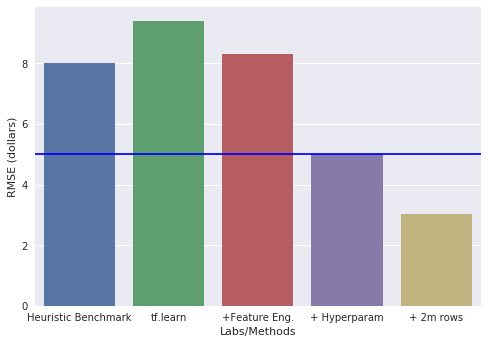

/usr/local/envs/py2env/lib/python2.7/site-packages/simplejson/encoder.py:296: DeprecationWarning: Interpreting naive datetime as local 2018-08-08 14:43:25.704945. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [24]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

df = pd.DataFrame({'Lab' : pd.Series(['1a', '2-3', '4a', '4b', '4c']),
              'Method' : pd.Series(['Heuristic Benchmark', 'tf.learn', '+Feature Eng.', '+ Hyperparam', '+ 2m rows']),
              'RMSE': pd.Series([8.026, 9.4, 8.3, 5.0, 3.03]) })

ax = sns.barplot(data = df, x = 'Method', y = 'RMSE')
ax.set_ylabel('RMSE (dollars)')
ax.set_xlabel('Labs/Methods')
plt.plot(np.linspace(-20, 120, 1000), [5] * 1000, 'b');

In [ ]:
%bash
gsutil -m mv gs://${BUCKET}/taxifare/ch4/  gs://${BUCKET}/taxifare/ch4_1m/

Copyright 2016 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License